In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import os

# Configuration
CSV_FILE = "results_1.5.csv"
os.makedirs("plots", exist_ok=True)

# Load data
df = pd.read_csv(CSV_FILE)

# Data validation and normalization
time_cols = ["time_init", "time_thread_create", "time_compute", 
             "time_thread_join", "time_cleanup", "time_total"]

for col in time_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=time_cols)

# Filter out 16 threads data to avoid scale distortion from sense_reversal
df = df[df['threads'] != 16]

# Get unique values
unique_users = sorted(df["user"].unique())
unique_iterations = sorted(df["iterations"].unique())
unique_threads = sorted(df["threads"].unique())

# Color scheme - one color per barrier type
colors = {
    "pthread": "#3498db",        # Blue
    "cond_var": "#e74c3c",       # Red
    "sense_reversal": "#2ecc71"  # Green
}

# Patterns for different iteration counts
iteration_patterns = {
    10000: '..',    # Dots
    50000: '//',    # Diagonal lines
    100000: 'xx'    # Cross-hatch
}

barrier_types = ["pthread", "cond_var", "sense_reversal"]

# Track saved plots to avoid duplicates
_saved_plot_paths = set()

print(f"Loaded {len(df)} data points")
print(f"Users: {unique_users}")
print(f"Iterations: {unique_iterations}")
print(f"Threads: {unique_threads}")
print(f"Barrier types: {df['barrier_type'].unique()}")

Loaded 330 data points
Users: ['ea24205', 'marr', 'phoebus']
Iterations: [np.int64(10000), np.int64(50000), np.int64(100000)]
Threads: [np.int64(2), np.int64(4), np.int64(8)]
Barrier types: ['pthread' 'cond_var' 'sense_reversal']


In [10]:
# Helper function for error propagation
def calculate_error_bars(df_group):
    """Calculate mean and std for each barrier type"""
    stats = df_group.groupby('barrier_type')['time_compute'].agg(['mean', 'std']).reset_index()
    return stats


Generating relative performance comparison...
  Saved: plots/plot_1_5_ea24205_relative_performance.png
  Saved: plots/plot_1_5_ea24205_relative_performance.png


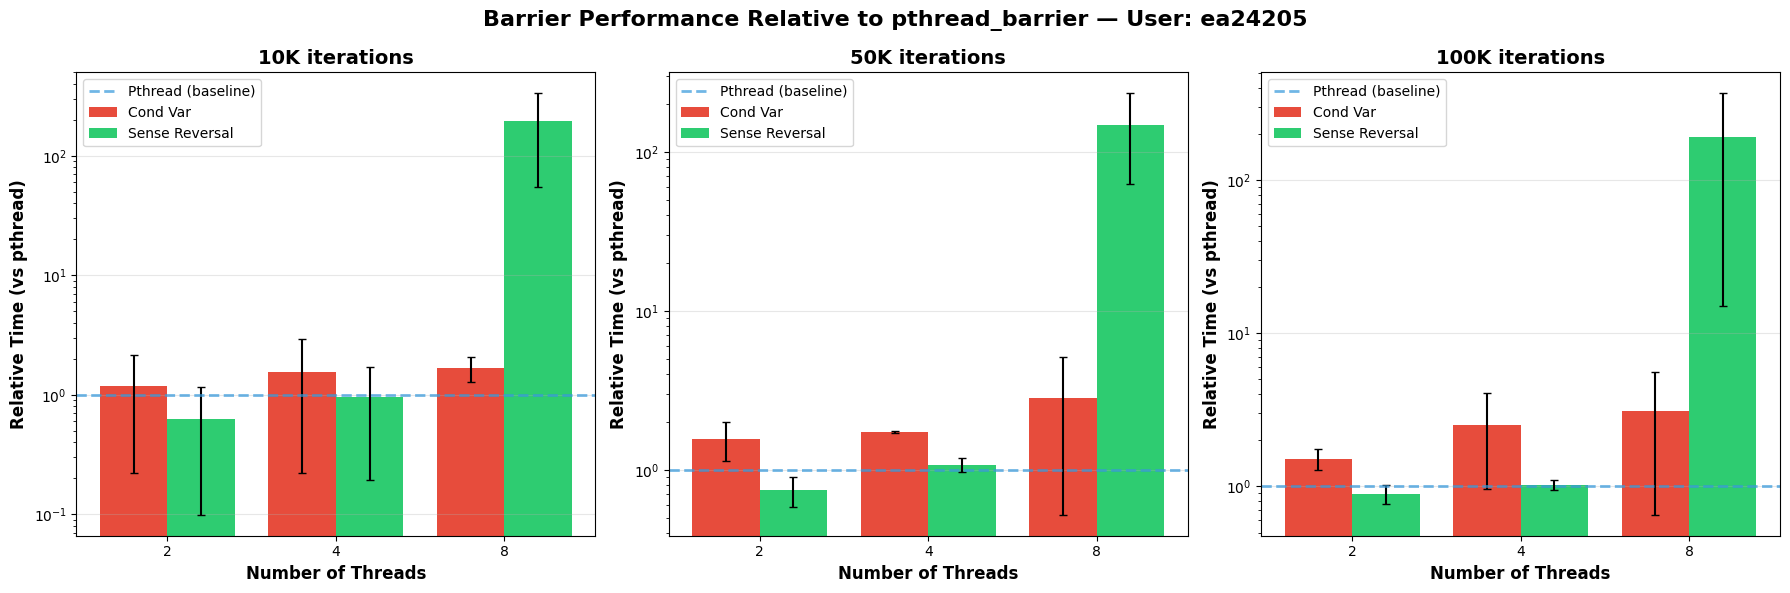

  Saved: plots/plot_1_5_marr_relative_performance.png


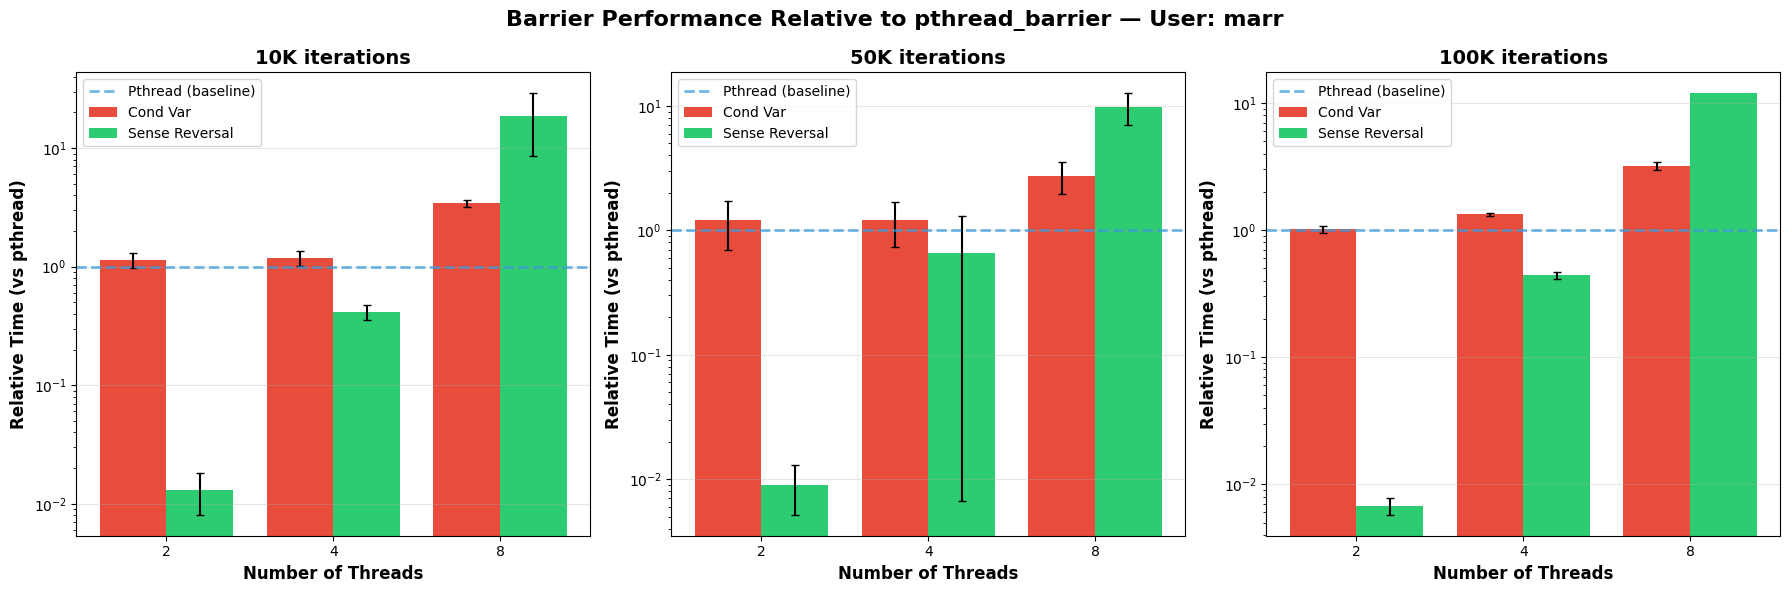

  Saved: plots/plot_1_5_phoebus_relative_performance.png


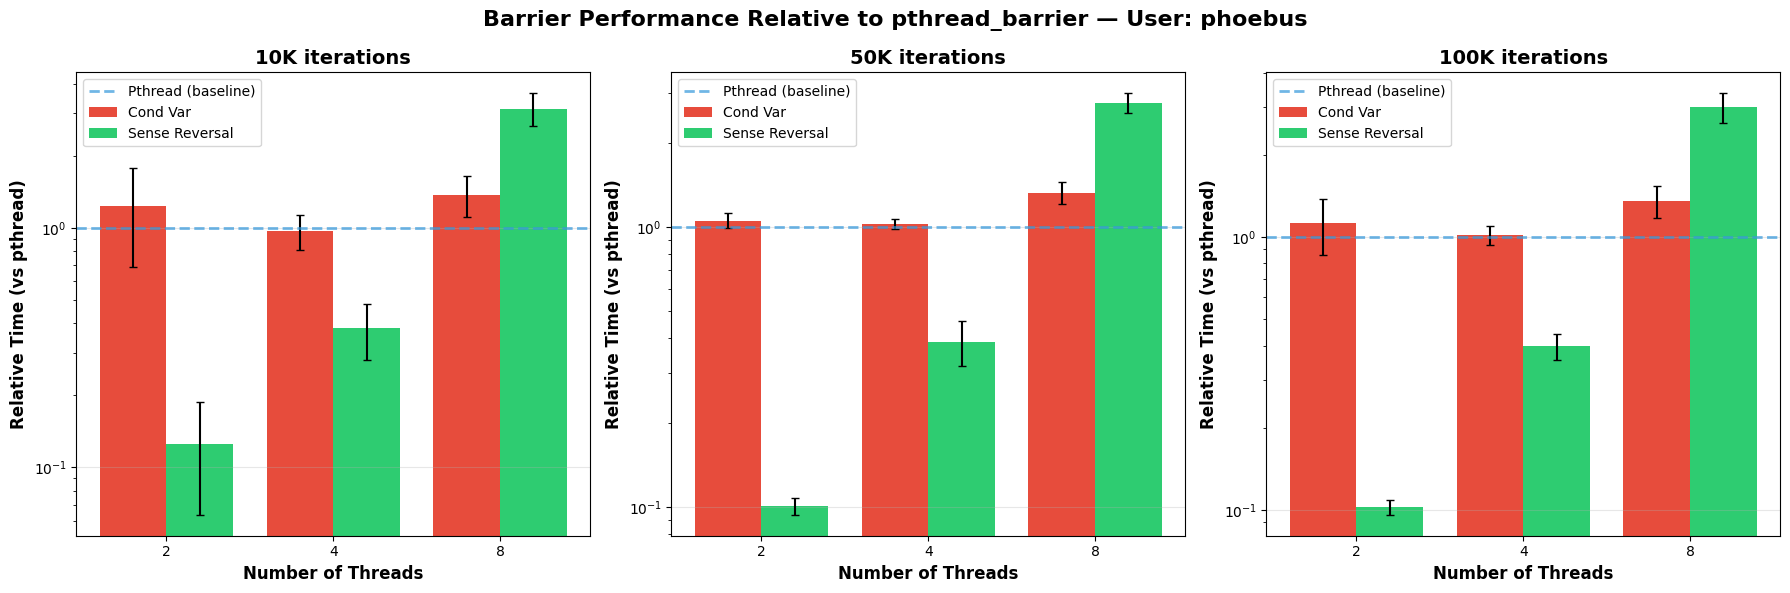

In [14]:
# Plot 4: Relative Performance Comparison (normalized to pthread)
print("\nGenerating relative performance comparison...")

# Create separate plots per user
for user in unique_users:
    fig, axes = plt.subplots(1, len(unique_iterations), figsize=(18, 6))
    
    if len(unique_iterations) == 1:
        axes = [axes]
    
    for idx, iters in enumerate(unique_iterations):
        ax = axes[idx]
        
        # Filter data for this user and iteration count
        # Exclude sense_reversal with 16 threads to avoid scale distortion
        user_iter_df = df[(df['user'] == user) & (df['iterations'] == iters)]
        user_iter_df = user_iter_df[~((user_iter_df['barrier_type'] == 'sense_reversal') & (user_iter_df['threads'] == 16))]
        
        # Group by barrier type and threads
        stats = user_iter_df.groupby(['barrier_type', 'threads'])['time_compute'].agg(['mean', 'std']).reset_index()
        
        # Calculate relative performance (normalized to pthread)
        x_positions = np.arange(len(unique_threads))
        num_bars = len(barrier_types) - 1  # Exclude pthread from bars
        bar_width = 0.8 / num_bars if num_bars > 0 else 0.8
        
        for bar_idx, barrier in enumerate([b for b in barrier_types if b != 'pthread']):
            relative_means = []
            relative_stds = []
            
            for threads in unique_threads:
                pthread_data = stats[(stats['barrier_type'] == 'pthread') & (stats['threads'] == threads)]
                barrier_data = stats[(stats['barrier_type'] == barrier) & (stats['threads'] == threads)]
                
                if len(pthread_data) > 0 and len(barrier_data) > 0:
                    pthread_time = pthread_data['mean'].values[0]
                    pthread_std = pthread_data['std'].values[0]
                    barrier_time = barrier_data['mean'].values[0]
                    barrier_std = barrier_data['std'].values[0]
                    
                    # Calculate relative time and error propagation
                    relative = barrier_time / pthread_time if pthread_time > 0 else 0
                    # Error propagation for division: (a/b) has error sqrt((da/a)^2 + (db/b)^2) * (a/b)
                    if pthread_time > 0 and barrier_time > 0:
                        relative_error = relative * np.sqrt((barrier_std/barrier_time)**2 + (pthread_std/pthread_time)**2)
                        # Clamp error to not exceed mean
                        relative_error = min(relative_error, relative)
                    else:
                        relative_error = 0
                    
                    relative_means.append(relative)
                    relative_stds.append(relative_error)
                else:
                    relative_means.append(0)
                    relative_stds.append(0)
            
            offset = (bar_idx - num_bars/2 + 0.5) * bar_width if num_bars > 0 else 0
            bars = ax.bar(x_positions + offset, relative_means, bar_width, 
                         label=barrier.replace('_', ' ').title(),
                         color=colors[barrier], yerr=relative_stds, capsize=3)
        
        # Add reference line at y=1.0
        ax.axhline(y=1.0, color='#3498db', linestyle='--', linewidth=2, label='Pthread (baseline)', alpha=0.7)
        
        ax.set_xlabel('Number of Threads', fontsize=12, fontweight='bold')
        ax.set_ylabel('Relative Time (vs pthread)', fontsize=12, fontweight='bold')
        ax.set_yscale('log')
        ax.set_title(f'{int(iters/1000)}K iterations', fontsize=14, fontweight='bold')
        ax.set_xticks(x_positions)
        ax.set_xticklabels(unique_threads)
        ax.legend(loc='upper left', frameon=True)
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle(f'Barrier Performance Relative to pthread_barrier — User: {user}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save plot
    outpath = f"plots/plot_1_5_{user}_relative_performance.png"
    if outpath not in _saved_plot_paths:
        fig.savefig(outpath, dpi=150, bbox_inches='tight')
        _saved_plot_paths.add(outpath)
        print(f"  Saved: {outpath}")
    
    plt.show()
    plt.close()